In [1]:
import pandas as pd
import numpy as np
from pprint import pprint
import matplotlib.pyplot as plt 
import seaborn as sns

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import lightgbm as lgb

from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error


from functions import df_engineered, r2rmse_scores

import pickle
import time

In [2]:
feature_selection = ['ExterQual', 'BsmtQual', 'KitchenQual', 'OverallQual', 
                    'GrLivArea', 'TotalBsmtSF', 'GarageArea', 'FullBath', 
                    'HouseAge', 'TotRmsAbvGrd', 'OverallCond',  'FlrSF1st', 'FlrSF2nd',
                    'Fireplaces', 'HasFireplace','LotFrontage', 'LotArea', 'MSSubClass', 'GoodGarageType', 
                    'BsmtUnfSF', 'Zone', 'Location', 'CulDSac', 'ExQual', 'RemodAge',
                    'Remod', 'ExBsmtQual', 'TwoStory', 'TotalSF', 'RoadRail', 'ExKitchen', 'CentralAir',
                    'TotalBath', 'Exterior1st_top', 'BedroomPerSF']

In [3]:
df = pd.read_csv('data/Ames_Housing_Price_Data.csv', index_col=0).iloc[:,1:]
print('df shape:', df.shape)

data = df_engineered(df, Reg=False)

df shape: (2580, 80)


In [4]:
X_train, X_test, y_train, y_test = train_test_split(data[feature_selection], data['SalePrice'], test_size=0.30, random_state=42)

## Random Forest

#### Untuned model

In [5]:
rf_untuned = GradientBoostingRegressor(random_state=42)
rf_untuned.fit(X_train, y_train)

r2rmse_scores(rf_untuned, X_train, y_train)

--------------------------------------------------
5-fold Cross Validation Scoring
Mean R^2 score: 0.9310615690925885
Mean RMSE score: 18358.699806467466
--------------------------------------------------


In [6]:
yhat_train = rf_untuned.predict(X_train)
yhat_test = rf_untuned.predict(X_test)

train_rmse_non_log = mean_squared_error(y_train, yhat_train, squared=False)
test_rmse_non_log = mean_squared_error(y_test, yhat_test, squared=False)

print(train_rmse_non_log)
print(test_rmse_non_log)

12384.338839886956
19673.021134613056


#### Tuned Model

In [7]:
n_estimators = [int(x) for x in np.linspace(start = 90, stop = 100, num = 10)]
max_features = ['sqrt', 'log2']
max_depth = [int(x) for x in np.linspace(3, 10, num = 7)]
min_samples_split = [2, 5, 10, 15]
min_samples_leaf = [4, 8, 12, 15]
bootstrap = [True, False]


random_grid = [{'n_estimators': n_estimators,
               'max_features': max_features,
               'bootstrap': bootstrap,
               'max_features':max_features,
               'min_samples_split': min_samples_split},
               {
               'n_estimators': n_estimators,
               'max_features': max_features,
               'bootstrap': bootstrap,   
               'max_features':max_features,
               'min_samples_leaf': min_samples_leaf}]

pprint(random_grid)

[{'bootstrap': [True, False],
  'max_features': ['sqrt', 'log2'],
  'min_samples_split': [2, 5, 10, 15],
  'n_estimators': [90, 91, 92, 93, 94, 95, 96, 97, 98, 100]},
 {'bootstrap': [True, False],
  'max_features': ['sqrt', 'log2'],
  'min_samples_leaf': [4, 8, 12, 15],
  'n_estimators': [90, 91, 92, 93, 94, 95, 96, 97, 98, 100]}]


In [8]:
rf = RandomForestRegressor(random_state=42)

rf_random = RandomizedSearchCV(estimator=rf, 
                               param_distributions=random_grid, 
                               n_iter=100, 
                               cv=3, 
                               verbose=1, 
                               random_state=42, 
                               n_jobs = -1)

rf_random.fit(X_train, y_train)

r2rmse_scores(rf_random, X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


Fitting 3 folds for each of 100 candidates, totalling 300 fits
Fitting 3 folds for each of 100 candidates, totalling 300 fits
Fitting 3 folds for each of 100 candidates, totalling 300 fits
Fitting 3 folds for each of 100 candidates, totalling 300 fits
Fitting 3 folds for each of 100 candidates, totalling 300 fits
--------------------------------------------------
5-fold Cross Validation Scoring
Mean R^2 score: 0.9199269467124189
Mean RMSE score: 19837.24823564478
--------------------------------------------------


In [9]:
yhat_train = rf_random.predict(X_train)
yhat_test = rf_random.predict(X_test)

train_rmse_non_log = mean_squared_error(y_train, yhat_train, squared=False)
test_rmse_non_log = mean_squared_error(y_test, yhat_test, squared=False)

print(train_rmse_non_log)
print(test_rmse_non_log)

4237.840848667295
19841.309523295076


In [10]:
yhat_train = rf_random.predict(X_train)
yhat_test = rf_random.predict(X_test)

train_mape = mean_absolute_percentage_error(y_train, yhat_train)
test_mape = mean_absolute_percentage_error(y_test, yhat_test)

print(train_mape)
print(test_mape)

0.014788717920712775
0.08155216836714706


In [11]:
#Get the parameters of the best forest
rf_random.best_params_

{'n_estimators': 97,
 'min_samples_split': 5,
 'max_features': 'log2',
 'bootstrap': False}

In [12]:
#Run a RF with the best parements and obtain the feature importance
rf_best = RandomForestRegressor(n_estimators=91, min_samples_split=2, \
                                max_features='sqrt', bootstrap=False, \
                                random_state=42)
rf_best.fit(X_train, y_train)

feature_names = [f"feature {i}" for i in range(X_train.shape[1])]
importances = rf_best.feature_importances_
forest_importances = pd.Series(importances, index=X_train.columns).\
                               sort_values(ascending=False).to_frame().\
                                reset_index()
forest_importances.columns = ['feature', 'MDI']
forest_importances

,feature,MDI
0,TotalSF,0.143566
1,OverallQual,0.107773
2,GrLivArea,0.087643
3,Location,0.080604
4,ExQual,0.076263
5,ExterQual,0.048191
6,TotalBath,0.044428
7,TotalBsmtSF,0.043461
8,HouseAge,0.039980
9,GarageArea,0.037232


Text(0, 0.5, 'Mean decrease in impurity')

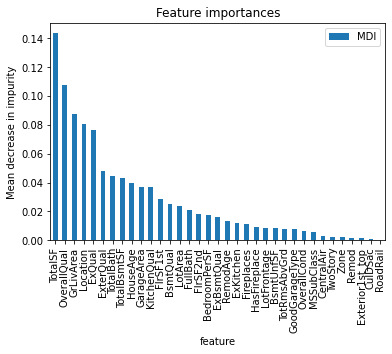

In [13]:
#bar plot feature by importance
fig = forest_importances.plot.bar(x='feature')
fig.set_title("Feature importances")
fig.set_ylabel("Mean decrease in impurity")


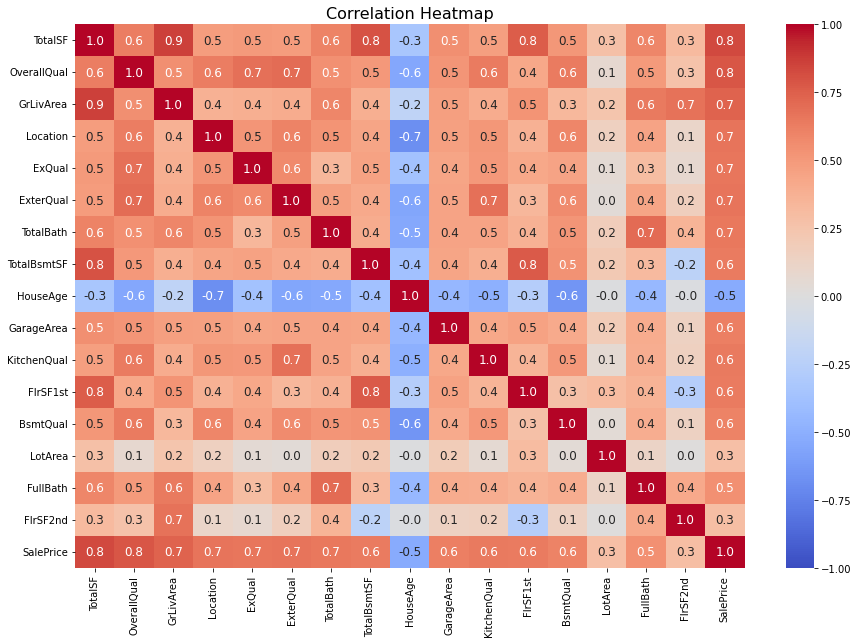

In [14]:
# Calculate the correlation matrix of the first 16 features
features_16 = forest_importances['feature'][0:16].tolist()
corr_mat = data[features_16 + ['SalePrice']].corr()

# Create the heatmap
plt.figure(figsize=(15, 10))
sns.heatmap(corr_mat,
            annot=True,
            fmt='.1f',
            vmin=-1,
            vmax=1,
            cmap='coolwarm',
            annot_kws={"size": 12}  # Set fontsize for annotations
            )

# Set the title
title = plt.title('Correlation Heatmap', fontsize=16)

# Display the plot
plt.show()


In [15]:
features_16 = [col for col in features_16 if col != 'Location']

In [16]:
#Scale features:
%store -r X_train 
%store -r X_test 
%store -r y_train 
%store -r y_test 

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train[features_16]), columns=X_train[features_16].columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test[features_16]), columns=X_test[features_16].columns)


no stored variable or alias X_train
no stored variable or alias X_test
no stored variable or alias y_train
no stored variable or alias y_test


In [17]:
#train LR based on rf feature selection

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold, cross_val_score

ols = LinearRegression()
ols.fit(X_train_scaled[features_16], y_train)

kf = KFold(n_splits=5, shuffle=True, random_state=10)
cv_scores_shuffled = cross_val_score(ols, X_train_scaled, y_train, cv=kf)
cv_results_RMSE = np.sqrt(-cross_val_score(ols, X_train_scaled, y_train, scoring="neg_mean_squared_error", cv=kf))
cv_results_RMSE = np.sqrt(-cross_val_score(ols, X_train_scaled, y_train, scoring="neg_mean_squared_error", cv=kf))


print('Shuffled cross validation score:', np.round(cv_scores_shuffled, 4))
print('Mean shuffled cross validation score:', np.round(cv_scores_shuffled.mean(), 4))

print('RMSE Shuffled cross validation score:', np.round(cv_results_RMSE, 4))
print('RMSE Mean shuffled cross validation score:', np.round(cv_results_RMSE.mean(), 4))

Shuffled cross validation score: [0.8496 0.8586 0.863  0.869  0.8916]
Mean shuffled cross validation score: 0.8664
RMSE Shuffled cross validation score: [25366.1104 27469.6627 25255.4251 26483.411  23441.3413]
RMSE Mean shuffled cross validation score: 25603.1901


In [18]:
test_score = ols.score(X_test_scaled, y_test)

print('Test score:', np.round(test_score, 4))

rms = mean_squared_error(y_test, ols.predict(X_test_scaled), squared=False)
print('RMSE Test score:', np.round(rms, 4))

Test score: 0.8682
RMSE Test score: 26025.9213


#### Save best model

In [19]:
df.columns

Index(['GrLivArea', 'SalePrice', 'MSSubClass', 'MSZoning', 'LotFrontage',
       'LotArea', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt',
       'YearRemodAdd', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd',
       'MasVnrType', 'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', 'FlrSF1st', 'FlrSF2nd',
       'LowQualFinSF', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond',
       'Pav

In [20]:
#file_name = "rf_reg_{}.pkl".format(time.strftime("%Y%m%d-%H.%M.%S"))

# save
#pickle.dump(rf_random, open("saved_models/{}".format(file_name), "wb"))

# load
# file_name='rf_reg_20230719-14.40.17.pkl'
# rf_model_loaded = pickle.load(open("saved_models/{}".format(file_name), "rb"))

In [21]:
# yhat_train = rf_model_loaded.predict(X_train)
# yhat_test = rf_model_loaded.predict(X_test)

# train_rmse_non_log = mean_squared_error(y_train, yhat_train, squared=False)
# test_rmse_non_log = mean_squared_error(y_test, yhat_test, squared=False)

# print(train_rmse_non_log)
# print(test_rmse_non_log)

## XGBoost sklearn

#### Untuned model

In [22]:
xgb_untuned = GradientBoostingRegressor(random_state=42)
xgb_untuned.fit(X_train, y_train)

r2rmse_scores(xgb_untuned, X_train, y_train)

--------------------------------------------------
5-fold Cross Validation Scoring
Mean R^2 score: 0.9310615690925885
Mean RMSE score: 18358.699806467466
--------------------------------------------------


In [23]:
yhat_train = xgb_untuned.predict(X_train)
yhat_test = xgb_untuned.predict(X_test)

train_rmse_non_log = mean_squared_error(y_train, yhat_train, squared=False)
test_rmse_non_log = mean_squared_error(y_test, yhat_test, squared=False)

print(train_rmse_non_log)
print(test_rmse_non_log)

12384.338839886956
19673.021134613056


#### Tuned Model

In [24]:
n_estimators = [int(x) for x in np.linspace(start = 160, stop = 180, num = 10)]
max_features = ['sqrt', 'log2']
max_depth = [int(x) for x in np.linspace(1, 5, num = 5)]
min_samples_split = [4, 6, 8, 10]
min_samples_leaf = [2,3,4,5]
learning_rate = [0.01, 0.1, 0.2, 0.3]
alpha = [0.1, 0.2, 0.3, 0.4]
subsample = [0.6, 0.8, 0.9]

random_grid = [{'n_estimators': n_estimators,
               'max_features': max_features,
               'learning_rate':learning_rate,
               'alpha':alpha,
               'max_depth':max_depth,
               'subsample':subsample,
               'min_samples_split': min_samples_split},
               {
               'n_estimators': n_estimators,
               'max_features': max_features, 
               'learning_rate':learning_rate,
               'alpha':alpha,
               'max_depth':max_depth,
               'subsample':subsample,
               'min_samples_leaf': min_samples_leaf}]

pprint(random_grid)

[{'alpha': [0.1, 0.2, 0.3, 0.4],
  'learning_rate': [0.01, 0.1, 0.2, 0.3],
  'max_depth': [1, 2, 3, 4, 5],
  'max_features': ['sqrt', 'log2'],
  'min_samples_split': [4, 6, 8, 10],
  'n_estimators': [160, 162, 164, 166, 168, 171, 173, 175, 177, 180],
  'subsample': [0.6, 0.8, 0.9]},
 {'alpha': [0.1, 0.2, 0.3, 0.4],
  'learning_rate': [0.01, 0.1, 0.2, 0.3],
  'max_depth': [1, 2, 3, 4, 5],
  'max_features': ['sqrt', 'log2'],
  'min_samples_leaf': [2, 3, 4, 5],
  'n_estimators': [160, 162, 164, 166, 168, 171, 173, 175, 177, 180],
  'subsample': [0.6, 0.8, 0.9]}]


In [25]:
xgb = GradientBoostingRegressor(random_state=0)

xgb_random = RandomizedSearchCV(estimator=xgb, 
                               param_distributions=random_grid, 
                               n_iter=200, 
                               cv=3, 
                               verbose=1, 
                               random_state=42, 
                               n_jobs = -1)

xgb_random.fit(X_train, y_train)

r2rmse_scores(xgb_random, X_train, y_train)

Fitting 3 folds for each of 200 candidates, totalling 600 fits


Fitting 3 folds for each of 200 candidates, totalling 600 fits
Fitting 3 folds for each of 200 candidates, totalling 600 fits
Fitting 3 folds for each of 200 candidates, totalling 600 fits
Fitting 3 folds for each of 200 candidates, totalling 600 fits
Fitting 3 folds for each of 200 candidates, totalling 600 fits
--------------------------------------------------
5-fold Cross Validation Scoring
Mean R^2 score: 0.9325529320673256
Mean RMSE score: 18162.14666035471
--------------------------------------------------


In [26]:
yhat_train = xgb_random.predict(X_train)
yhat_test = xgb_random.predict(X_test)

train_rmse_non_log = mean_squared_error(y_train, yhat_train, squared=False)
test_rmse_non_log = mean_squared_error(y_test, yhat_test, squared=False)

print(train_rmse_non_log)
print(test_rmse_non_log)

12009.196249102466
17590.18165812109


In [27]:
yhat_train = xgb_random.predict(X_train)
yhat_test = xgb_random.predict(X_test)

train_mape = mean_absolute_percentage_error(y_train, yhat_train)
test_mape = mean_absolute_percentage_error(y_test, yhat_test)

print(train_mape)
print(test_mape)

0.05491737168879378
0.07750584126792322


#### Save best model

In [28]:
#file_name = "xgb_reg_{}.pkl".format(time.strftime("%Y%m%d-%H.%M.%S"))

# save
#pickle.dump(xgb_random, open('saved_models/{}'.format(file_name), "wb"))

# load
# file_name='xgb_reg_20230719-13.12.55.pkl'
# xgb_model_loaded = pickle.load(open('saved_models/{}'.format(file_name), "rb"))

In [29]:
# yhat_train = xgb_model_loaded.predict(X_train)
# yhat_test = xgb_model_loaded.predict(X_test)

# train_rmse_non_log = mean_squared_error(y_train, yhat_train, squared=False)
# test_rmse_non_log = mean_squared_error(y_test, yhat_test, squared=False)

# print(train_rmse_non_log)
# print(test_rmse_non_log)

## LightGBM

#### Untuned model

In [30]:
lgbm = lgb.LGBMRegressor()
lgbm.fit(X_train, y_train)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012127 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2646
[LightGBM] [Info] Number of data points in the train set: 1678, number of used features: 35
[LightGBM] [Info] Start training from score 176659.575089


LGBMRegressor()

In [31]:
yhat_train = lgbm.predict(X_train)
yhat_test = lgbm.predict(X_test)

train_rmse_non_log = mean_squared_error(y_train, yhat_train, squared=False)
test_rmse_non_log = mean_squared_error(y_test, yhat_test, squared=False)

print(train_rmse_non_log)
print(test_rmse_non_log)

8904.857150918504
21843.282960841716


#### Tuned Model

In [32]:
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 190, num = 10)]
max_depth = [int(x) for x in np.linspace(2, 5, num = 3)]
learning_rate = [0.08, 0.1, 0.2, 0.3]
alpha = [0.1, 0.2, 0.3, 0.4]
subsample = [0.6, 0.8, 0.9]
min_child_samples = [3,4, 5, 6,7]
colsample_bytree = [0.7, 0.8, 0.9]

random_grid = [{'n_estimators': n_estimators,
               'learning_rate':learning_rate,
               'alpha':alpha,
               'max_depth':max_depth,
               'subsample':subsample,
               'min_child_samples':min_child_samples,
               'colsample_bytree':colsample_bytree}]

random_grid

[{'n_estimators': [10, 30, 50, 70, 90, 110, 130, 150, 170, 190],
  'learning_rate': [0.08, 0.1, 0.2, 0.3],
  'alpha': [0.1, 0.2, 0.3, 0.4],
  'max_depth': [2, 3, 5],
  'subsample': [0.6, 0.8, 0.9],
  'min_child_samples': [3, 4, 5, 6, 7],
  'colsample_bytree': [0.7, 0.8, 0.9]}]

In [33]:
lgbm = lgb.LGBMRegressor(objective='regression', 
                                random_state=42)

lgbm_random = RandomizedSearchCV(estimator=lgbm, 
                      param_distributions=random_grid,
                      n_iter=300, 
                      cv=5, 
                      verbose=1, 
                      random_state=42, 
                      n_jobs = -1,
                      scoring='neg_root_mean_squared_error')

lgbm_random.fit(X_train, y_train)

r2rmse_scores(lgbm_random, X_train, y_train)

Fitting 5 folds for each of 300 candidates, totalling 1500 fits


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009042 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2646
[LightGBM] [Info] Number of data points in the train set: 1678, number of used features: 35
[LightGBM] [Info] Start training from score 176659.575089
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

In [34]:
yhat_train = lgbm_random.predict(X_train)
yhat_test = lgbm_random.predict(X_test)

train_rmse_non_log = mean_squared_error(y_train, yhat_train, squared=False)
test_rmse_non_log = mean_squared_error(y_test, yhat_test, squared=False)

print(train_rmse_non_log)
print(test_rmse_non_log)

11751.728057183545
18523.89613062565


In [35]:
yhat_train = lgbm_random.predict(X_train)
yhat_test = lgbm_random.predict(X_test)

train_mape = mean_absolute_percentage_error(y_train, yhat_train)
test_mape = mean_absolute_percentage_error(y_test, yhat_test)

print(train_mape)
print(test_mape)

0.053013902550800414
0.07642621570702804


In [36]:
lgbm_random.best_params_

{'subsample': 0.8,
 'n_estimators': 170,
 'min_child_samples': 5,
 'max_depth': 3,
 'learning_rate': 0.08,
 'colsample_bytree': 0.7,
 'alpha': 0.4}

#### Save best model

In [37]:
#file_name = "lgbm_reg_{}.pkl".format(time.strftime("%Y%m%d-%H.%M.%S"))

# save
#pickle.dump(lgbm_random, open('saved_models/{}'.format(file_name), "wb"))

# load
# file_name='lgbm_reg_20230719-15.03.27.pkl'
# lgbm_model_loaded = pickle.load(open('saved_models/{}'.format(file_name), "rb"))

In [38]:
# yhat_train = lgbm_model_loaded.predict(X_train)
# yhat_test = lgbm_model_loaded.predict(X_test)

# train_rmse_non_log = mean_squared_error(y_train, yhat_train, squared=False)
# test_rmse_non_log = mean_squared_error(y_test, yhat_test, squared=False)

# print(train_rmse_non_log)
# print(test_rmse_non_log)